## ARGE Çalışması

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('Northwind.csv')

In [8]:
import pandas as pd

# order_date sütunu datetime değilse dönüştür
df['order_date'] = pd.to_datetime(df['order_date'])

# 1. Aynı müşteri ve aynı tarihteki siparişleri tekilleştir
df_unique = df.drop_duplicates(subset=['customer_id', 'order_date'])



In [9]:
# 2. Sıralama
df_unique = df_unique.sort_values(['customer_id', 'order_date']).reset_index(drop=True)



In [10]:
# 3. Bir sonraki siparişin tarihini bul
df_unique['next_order_date'] = df_unique.groupby('customer_id')['order_date'].shift(-1)


In [11]:
# 4. Gün farkını hesapla
df_unique['days_diff'] = (df_unique['next_order_date'] - df_unique['order_date']).dt.days



In [12]:
# 5. 180 günden az olanları işaretle
df_unique['less_than_180'] = df_unique['days_diff'] < 180



In [13]:
# 6. Özet tablo
summary = df_unique.groupby('customer_id').agg(
    total_orders=('order_date', 'count'),
    orders_less_than_180=('less_than_180', 'sum')
).reset_index()

summary['percentage_less_than_180'] = 100 * summary['orders_less_than_180'] / summary['total_orders']
summary = summary.round(2)

# Sonuç
print(summary.head())

  customer_id  total_orders  orders_less_than_180  percentage_less_than_180
0       ALFKI             6                     5                     83.33
1       ANATR             4                     2                     50.00
2       ANTON             7                     6                     85.71
3       AROUT            13                    12                     92.31
4       BERGS            18                    17                     94.44


In [13]:
print(summary)

   customer_id  total_orders  orders_less_than_180  percentage_less_than_180
0        ALFKI             6                     5                     83.33
1        ANATR             4                     2                     50.00
2        ANTON             7                     6                     85.71
3        AROUT            13                    12                     92.31
4        BERGS            18                    17                     94.44
..         ...           ...                   ...                       ...
84       WARTH            15                    14                     93.33
85       WELLI             9                     7                     77.78
86       WHITC            14                    13                     92.86
87       WILMK             7                     6                     85.71
88       WOLZA             7                     5                     71.43

[89 rows x 4 columns]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(summary['percentage_less_than_180'], bins=10, kde=True)
plt.xlabel('% of orders < 180 days apart')
plt.title('Dağılım: percentage_less_than_180')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [15]:
summary['target'] = summary['percentage_less_than_180'].apply(lambda x: 1 if x >= 60 else 0)

In [16]:
summary['risk_group'] = pd.qcut(summary['percentage_less_than_180'], q=4, labels=['low', 'mid-low', 'mid-high', 'high'])

In [17]:
summary

,customer_id,total_orders,orders_less_than_180,percentage_less_than_180,target,risk_group
0,ALFKI,6,5,83.33,1,mid-high
1,ANATR,4,2,50.00,0,low
2,ANTON,7,6,85.71,1,mid-high
3,AROUT,13,12,92.31,1,high
4,BERGS,18,17,94.44,1,high
...,...,...,...,...,...,...
84,WARTH,15,14,93.33,1,high
85,WELLI,9,7,77.78,1,mid-low
86,WHITC,14,13,92.86,1,high
87,WILMK,7,6,85.71,1,mid-high


## Mevsimsel Satış 

In [18]:
df

,order_id,customer_id,order_date,ship_country,unit_price,quantity,discount,category_id,product_id,order_size,season
0,10248,VINET,1996-07-04,France,14.00,12,0.00,4,11,168.000,Summer
1,10248,VINET,1996-07-04,France,9.80,10,0.00,5,42,98.000,Summer
2,10248,VINET,1996-07-04,France,34.80,5,0.00,4,72,174.000,Summer
3,10249,TOMSP,1996-07-05,Germany,18.60,9,0.00,7,14,167.400,Summer
4,10249,TOMSP,1996-07-05,Germany,42.40,40,0.00,7,51,1696.000,Summer
...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,1998-05-06,USA,33.25,2,0.03,5,64,64.505,Spring
2151,11077,RATTC,1998-05-06,USA,17.00,1,0.00,2,66,17.000,Spring
2152,11077,RATTC,1998-05-06,USA,15.00,2,0.01,8,73,29.700,Spring
2153,11077,RATTC,1998-05-06,USA,7.75,4,0.00,1,75,31.000,Spring


In [18]:
# 1. Sezon isimlerini (eşsiz) string olarak al
season_names = (
    df.groupby('customer_id')['season']
    .unique()
    .apply(lambda x: ', '.join(sorted(set(x))))
    .reset_index(name='season_names')
)

# 2. Kaç adet sezon kaydı var
count_season = (
    df.groupby('customer_id')['season']
    .count()
    .reset_index(name='count_season')
)

# 3. Birleştir
season_summary = pd.merge(season_names, count_season, on='customer_id')


In [19]:
season_summary['season_count'] = season_summary['season_names'].apply(lambda x: len(x.split(', ')))

In [20]:
season_summary

,customer_id,season_names,count_season,season_count
0,ALFKI,"Autumn, Spring, Summer, Winter",12,4
1,ANATR,"Autumn, Spring, Summer",10,3
2,ANTON,"Autumn, Spring, Summer, Winter",17,4
3,AROUT,"Autumn, Spring, Summer, Winter",30,4
4,BERGS,"Autumn, Spring, Summer, Winter",52,4
...,...,...,...,...
84,WARTH,"Autumn, Spring, Summer, Winter",37,4
85,WELLI,"Spring, Summer, Winter",19,3
86,WHITC,"Autumn, Spring, Summer, Winter",40,4
87,WILMK,"Autumn, Spring, Summer, Winter",17,4


In [21]:
#arge



# Sezonlara göre sipariş sayısı
#orders_by_season = df['season'].value_counts().sort_index()
#season_summary['season_count'] = season_summary['season_names'].apply(lambda x: len(x.split(', ')))

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=season_summary['season_count'].index, y=season_summary['season_count'].values)
plt.title("Sezonlara Göre Sipariş Sayısı")
plt.ylabel("Sipariş Sayısı")
plt.xlabel("Mevsim")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [24]:
df

,order_id,customer_id,order_date,ship_country,unit_price,quantity,discount,category_id,product_id,order_size,season
0,10248,VINET,1996-07-04,France,14.00,12,0.00,4,11,168.000,Summer
1,10248,VINET,1996-07-04,France,9.80,10,0.00,5,42,98.000,Summer
2,10248,VINET,1996-07-04,France,34.80,5,0.00,4,72,174.000,Summer
3,10249,TOMSP,1996-07-05,Germany,18.60,9,0.00,7,14,167.400,Summer
4,10249,TOMSP,1996-07-05,Germany,42.40,40,0.00,7,51,1696.000,Summer
...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,1998-05-06,USA,33.25,2,0.03,5,64,64.505,Spring
2151,11077,RATTC,1998-05-06,USA,17.00,1,0.00,2,66,17.000,Spring
2152,11077,RATTC,1998-05-06,USA,15.00,2,0.01,8,73,29.700,Spring
2153,11077,RATTC,1998-05-06,USA,7.75,4,0.00,1,75,31.000,Spring


## order_size üzerinden data augmentation

In [25]:
season_summary


,customer_id,season_names,count_season,season_count
0,ALFKI,"Autumn, Spring, Summer, Winter",12,4
1,ANATR,"Autumn, Spring, Summer",10,3
2,ANTON,"Autumn, Spring, Summer, Winter",17,4
3,AROUT,"Autumn, Spring, Summer, Winter",30,4
4,BERGS,"Autumn, Spring, Summer, Winter",52,4
...,...,...,...,...
84,WARTH,"Autumn, Spring, Summer, Winter",37,4
85,WELLI,"Spring, Summer, Winter",19,3
86,WHITC,"Autumn, Spring, Summer, Winter",40,4
87,WILMK,"Autumn, Spring, Summer, Winter",17,4


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mevsim sıralamasını korumak için:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Mevsime göre sipariş sayısı
orders_per_season = (
    df.groupby('season')['order_id']
    .nunique()
    .reindex(season_order)
)

# Mevsime göre toplam harcama (order_size)
spending_per_season = (
    df.groupby('season')['order_size']
    .sum()
    .reindex(season_order)
)



/var/folders/js/cdwgx9vj0pxfwkx_3pdxqgc80000gn/T/ipykernel_68208/3840399778.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_per_season.index, y=orders_per_season.values, palette="Blues_d")
/var/folders/js/cdwgx9vj0pxfwkx_3pdxqgc80000gn/T/ipykernel_68208/3840399778.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spending_per_season.index, y=spending_per_season.values, palette="Greens_d")


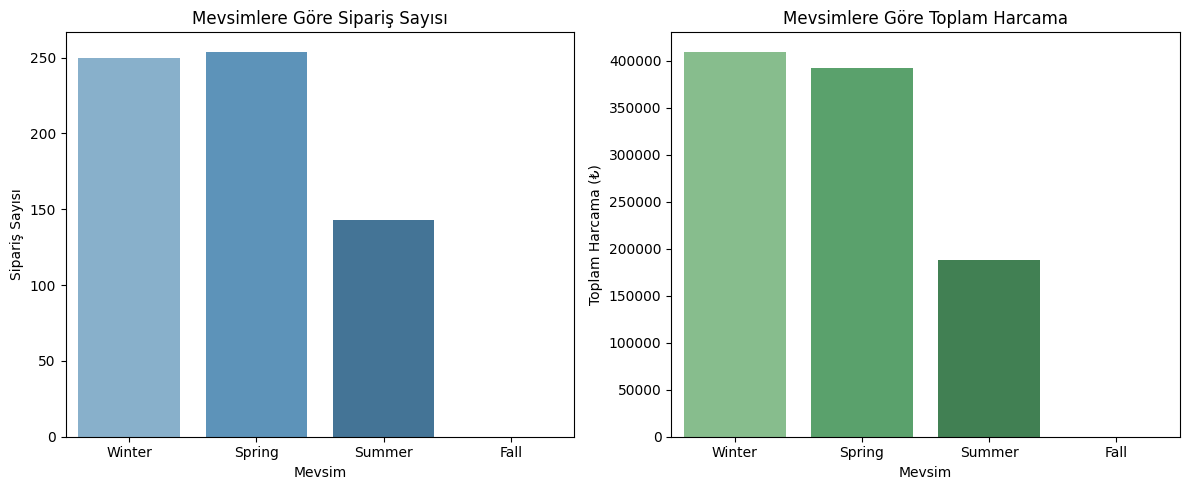

In [24]:
# sipariş sayısı & harcama karşılaştırması : 
plt.figure(figsize=(12, 5))

# Sipariş sayısı
plt.subplot(1, 2, 1)
sns.barplot(x=orders_per_season.index, y=orders_per_season.values, palette="Blues_d")
plt.title("Mevsimlere Göre Sipariş Sayısı")
plt.ylabel("Sipariş Sayısı")
plt.xlabel("Mevsim")

# Toplam harcama
plt.subplot(1, 2, 2)
sns.barplot(x=spending_per_season.index, y=spending_per_season.values, palette="Greens_d")
plt.title("Mevsimlere Göre Toplam Harcama")
plt.ylabel("Toplam Harcama (₺)")
plt.xlabel("Mevsim")

plt.tight_layout()
plt.show()


## Müşteri Bazında Özet Veri Oluşturma

In [25]:

# order_size sütunu varsa zaten total_spent gibi davranır.
customer_df = df.groupby('customer_id').agg({
    'order_id': 'nunique',
    'order_size': 'sum',
    'order_date': 'max'
}).rename(columns={
    'order_id': 'order_count',
    'order_size': 'total_spent',
    'order_date': 'last_order_date'
})

customer_df['avg_order_value'] = customer_df['total_spent'] / customer_df['order_count']
customer_df.reset_index(inplace=True)


In [26]:
# Sentetik Müşteri Verisi Oluşturma:

import numpy as np

# İstatistiksel özet
mean_order_count = customer_df['order_count'].mean()
std_order_count = customer_df['order_count'].std()

mean_total_spent = customer_df['total_spent'].mean()
std_total_spent = customer_df['total_spent'].std()

mean_avg_order_value = customer_df['avg_order_value'].mean()
std_avg_order_value = customer_df['avg_order_value'].std()

# Kaç müşteri üretelim?
n_synthetic = 200

# Sentetik müşteri üretimi
synthetic_customers = pd.DataFrame({
    'customer_id': [f'SYNTHETIC_{i}' for i in range(n_synthetic)],
    'order_count': np.random.normal(mean_order_count, std_order_count, n_synthetic).round().astype(int).clip(1),
    'total_spent': np.random.normal(mean_total_spent, std_total_spent, n_synthetic).clip(10),
    'avg_order_value': np.random.normal(mean_avg_order_value, std_avg_order_value, n_synthetic).clip(5)
})

# Eğer tutarsızlık varsa (örneğin total < avg * count), düzelt:
synthetic_customers['avg_order_value'] = synthetic_customers['total_spent'] / synthetic_customers['order_count']


In [27]:
# Etiket oluşturma :

# Etiketleri rastgele verelim (%50 sipariş veriyor gibi):
synthetic_customers['reorder_next_6_months'] = np.random.choice([0, 1], size=n_synthetic, p=[0.5, 0.5])


In [28]:
# merge 

# Gerçek veride de etiket olmalı — biz ekleyelim örnek olarak:
customer_df['reorder_next_6_months'] = np.random.choice([0, 1], size=len(customer_df), p=[0.7, 0.3])

# Sütunları eşleştir ve birleştir
combined_df = pd.concat([
    customer_df[['customer_id', 'order_count', 'total_spent', 'avg_order_value', 'reorder_next_6_months']],
    synthetic_customers
], ignore_index=True)


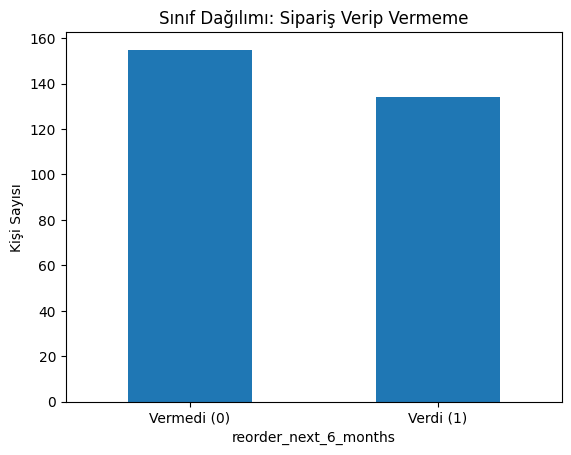

In [29]:
combined_df['reorder_next_6_months'].value_counts().plot(kind='bar')
plt.title("Sınıf Dağılımı: Sipariş Verip Vermeme")
plt.xticks([0, 1], ['Vermedi (0)', 'Verdi (1)'], rotation=0)
plt.ylabel("Kişi Sayısı")
plt.show()


## Class Imbalance: SMOTE ve class_weight Yöntemleri


In [30]:
# girdi özellikleri ve etiket ayırımı :

from sklearn.model_selection import train_test_split

X = combined_df[['order_count', 'total_spent', 'avg_order_value']]
y = combined_df['reorder_next_6_months']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [32]:
# smote kullanımı :

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Önce:", y_train.value_counts())
print("Sonra:", pd.Series(y_train_res).value_counts())


Önce: reorder_next_6_months
0    124
1    107
Name: count, dtype: int64
Sonra: reorder_next_6_months
1    124
0    124
Name: count, dtype: int64


In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_np = X_train_scaled.astype(np.float32)
y_train_np = y_train_res.astype(np.float32)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [59]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dropout(0.3), # 0.5 denendi
    Dense(32, activation='relu'),
    Dropout(0.2), # 0.5 denendi
    Dense(1, activation='sigmoid')  # ikili sınıflandırma için
])


/Users/elifdy/miniconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'f1_score'])


### 2. deneme by E Demirog

In [56]:
'''
model = Sequential([
    Dense(units=10,activation="relu",input_shape=(X_train_np.shape[1],)),
    Dense(units=1)
])

model.compile(optimizer ="adam",loss="mean_squared_error",
              metrics=['accuracy', 'f1_score'])
'''

In [63]:
history = model.fit(X_train_np, y_train_np, 
                    validation_split=0.2, # 0.4 denendi
                    epochs=30, batch_size=32)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6041 - f1_score: 0.6076 - loss: 0.6745 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7515
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6208 - f1_score: 0.6022 - loss: 0.6629 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7559
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6046 - f1_score: 0.6070 - loss: 0.6524 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7609
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5898 - f1_score: 0.5951 - loss: 0.6617 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7625
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5296 - f1_score: 0.6635 - loss: 0.6924 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7581
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6035 - f1_score: 0.5976 - loss: 0.6674 - val_accuracy: 0.2600 - val_f1_score: 0.8636 - val_loss: 0.7606
Epoc

In [58]:
#test verisi ile değerlendirme: 
X_test_np = X_test_scaled.astype(np.float32)
y_pred = model.predict(X_test_np)
y_pred_class = (y_pred > 0.5).astype(int)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x322850b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
